Dataset: **Sleep-EDF Expanded**  
https://physionet.org/content/sleep-edfx/1.0.0/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly_resampler import FigureResampler


# Data loading

## Some EDF loading funcs

In [5]:
from src.data import load_signals, load_annotations, annotation_to_30s_labels


## Load some data

In [6]:
import os

# Path to your data folder
data_folder = 'data'

# List all files in the folder
files = os.listdir(data_folder)

# Initialize counters
psg_count = 0
hypnogram_count = 0

# Count the number of PSG and Hypnogram files
for file in files:
    if 'PSG' in file:
        psg_count += 1
    elif 'Hypnogram' in file:
        hypnogram_count += 1

print(f"Number of PSG files: {psg_count}")
print(f"Number of Hypnogram files: {hypnogram_count}")


Number of PSG files: 153
Number of Hypnogram files: 153


In [7]:
import os
from collections import defaultdict

# Path to your data folder
data_folder = 'data'

# List all files in the folder
files = os.listdir(data_folder)

# Dictionary to count PSG files based on the first 4 characters
psg_count = defaultdict(int)

# Count occurrences of PSG files by first 4 characters
for file in files:
    if 'PSG' in file:
        base = file[:6]
        psg_count[base] += 1

# Find and print repeating PSG files
repeating_psg = {base: count for base, count in psg_count.items() if count > 1}

if repeating_psg:
    print("Repeating PSG files based on the first 4 characters:")
    for base, count in repeating_psg.items():
        print(f"{base}-PSG: {count} times")
else:
    print("No repeating PSG files found.")


No repeating PSG files found.


In [8]:
import os

# Path to your data folder
data_folder = 'data'

# List all files in the folder
files = os.listdir(data_folder)

# Separate PSG and Hypnogram files
psg_files = [file for file in files if 'PSG' in file]
hypnogram_files = [file for file in files if 'Hypnogram' in file]

# Get the first 4 characters of the base names for comparison
psg_bases = {file[:6] for file in psg_files}
hypnogram_bases = {file[:6] for file in hypnogram_files}

# Find PSG files without corresponding Hypnogram
missing_hypnogram = psg_bases- hypnogram_bases

if missing_hypnogram:
    print("PSG files without a corresponding Hypnogram file:")
    for base in missing_hypnogram:
        print(f"{base}-PSG.edf")
else:
    print("All PSG files have corresponding Hypnogram files.")


All PSG files have corresponding Hypnogram files.


In [9]:
os.listdir("data")[:10]

['SC4001E0-PSG.edf',
 'SC4001EC-Hypnogram.edf',
 'SC4002E0-PSG.edf',
 'SC4002EC-Hypnogram.edf',
 'SC4011E0-PSG.edf',
 'SC4011EH-Hypnogram.edf',
 'SC4012E0-PSG.edf',
 'SC4012EC-Hypnogram.edf',
 'SC4021E0-PSG.edf',
 'SC4021EH-Hypnogram.edf']

In [10]:
len(os.listdir("data"))


306

=> In total 309 files (153 PSG files - 153 hypnogram files) => 7.1 GB

In [11]:
dfs = []
sorted_files = sorted(os.listdir("data"))
psg_hypnogram_files = [(p, h) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
df_files["subfolder"] = "data"
# Because for the SC study patients were monitored for 2 consecutive nights
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f[:5])
df_files


,psg_file,label_file,subfolder,patient_id
0,SC4001E0-PSG.edf,SC4001EC-Hypnogram.edf,data,SC400
1,SC4002E0-PSG.edf,SC4002EC-Hypnogram.edf,data,SC400
2,SC4011E0-PSG.edf,SC4011EH-Hypnogram.edf,data,SC401
3,SC4012E0-PSG.edf,SC4012EC-Hypnogram.edf,data,SC401
4,SC4021E0-PSG.edf,SC4021EH-Hypnogram.edf,data,SC402
...,...,...,...,...
148,SC4802G0-PSG.edf,SC4802GV-Hypnogram.edf,data,SC480
149,SC4811G0-PSG.edf,SC4811GG-Hypnogram.edf,data,SC481
150,SC4812G0-PSG.edf,SC4812GV-Hypnogram.edf,data,SC481
151,SC4821G0-PSG.edf,SC4821GC-Hypnogram.edf,data,SC482


In [12]:
paper_patients = [
    "SC400",
    "SC401",
    "SC402",
    "SC403",
    "SC404",
    "SC405",
    "SC406",
    "SC407",
    "SC408",
    "SC409",
    "SC410",
    "SC411",
    "SC412",
    "SC413",
    "SC414",
    "SC415",
    "SC416",
    "SC417",
    "SC418",
    "SC419",
]


In [13]:
df_files_paper = df_files[df_files.patient_id.isin(paper_patients)]
df_files_paper.psg_file.nunique()


39

In [14]:
df_files_paper.patient_id.nunique()


20

=> psg file can be used as recordingid   
=> patient id can be used as patient id 

In [15]:
df_files_other = df_files[~df_files.patient_id.isin(paper_patients)]
df_files_other.psg_file.nunique()


114

In [16]:
df_files_other.patient_id.nunique()


58

In [ ]:
    signal_dict = {}

    for idx in range(len(df_files)):
        sig, freq = load_signals(
            "data/" + df_files.iloc[idx].psg_file,
            only_info=True,
        )
        for s, f in zip(sig, freq):
            if (s, f) in signal_dict.keys():
                signal_dict[(s, f)].append(idx)
            else:
                signal_dict[(s, f)] = [idx]

    # Displays (sig, freq) #recordings
    [(k, len(v)) for k, v in signal_dict.items()]

[(('EEG Fpz-Cz', 100.0), 153),
 (('EEG Pz-Oz', 100.0), 153),
 (('EOG horizontal', 100.0), 153),
 (('Resp oro-nasal', 1.0), 153),
 (('EMG submental', 1.0), 153),
 (('Temp rectal', 1.0), 153),
 (('Event marker', 1.0), 153)]

In [ ]:
common_signals = [
    "EEG Fpz-Cz",
    "EEG Pz-Oz",
    "EOG horizontal",  # All have the same sampling rate (100 Hz)
    "EMG submental",  # 1 Hz for cassette
]


In [ ]:
data = load_signals(
    "data/" + df_files.iloc[0].psg_file,
    retrieve_signals=common_signals,
)
annotations = load_annotations(
    "data/" + df_files.iloc[0].label_file,
    "data/" + df_files.iloc[0].psg_file,
)


In [20]:
cats = [
    "Sleep stage ?",
    "Movement time",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
][::-1]


# EDA + pipeline (for 1 patient)

In [21]:
import psutil
import socket

def free_port(port):
    """Terminate the process using the specified port if it's occupied."""
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        # Check if the port is in use
        if s.connect_ex(('localhost', port)) == 0:
            # Port is in use, so we find the process and terminate it
            for proc in psutil.process_iter(['pid', 'name', 'connections']):
                for conn in proc.info['connections'] or []:
                    if conn.laddr.port == port:
                        print(f"Terminating process {proc.info['name']} (PID: {proc.info['pid']}) using port {port}.")
                        proc.terminate()  # Graceful termination
                        proc.wait()       # Ensure process is fully terminated
                        print(f"Process terminated.")
                        return  # Exit after terminating the process using the port
            print(f"No process found using port {port}.")
        else:
            print(f"Port {port} is already free.")

# Use the function to free up port 8041
free_port(8041)


Port 8041 is already free.


In [22]:
idxs = [s.name for s in data]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=2_000,
)

for idx, s in enumerate(data, 1):
    fig.add_trace(
        go.Scattergl(
            x=[],
            y=[],
            name=s.name,
            line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.add_trace(
    go.Scattergl(
        x=[],
        y=[],
        name="Hypnogram",
        line_width=1.5,
        line_shape="hv",
    ),
    hf_x=annotation_to_30s_labels(annotations).index,
    hf_y=annotation_to_30s_labels(annotations)["label"].astype("category"),
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=900)
fig.update_yaxes(categoryorder="array", categoryarray=cats)

fig.update_layout(
    legend_traceorder="normal",
    template="plotly_dark",
    #     legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8041)

c:\Artificial_intelligence\Bio_signal_processing\Project\src\data.py:106: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



## Process the signals

In [ ]:
## Processing
from scipy.signal import butter, lfilter

from tsflex.processing import SeriesPipeline, SeriesProcessor


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y


eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)
emg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EMG submental"],
    lowcut=0.5,
    highcut=10,
    fs=1,
)
process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
    ]
)

process_pipe


[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
]

In [24]:
%%time
data_processed = process_pipe.process(data, return_all_series=True)

CPU times: total: 125 ms
Wall time: 242 ms


In [25]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.show_dash(port=8041)


## Extract the features

In [26]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings


{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [27]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower

import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])
# fc


11-Nov-24 16:51:54 | ERROR | Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [28]:
import logging

from tsflex.features.logger import logger

logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger

logger.setLevel(level=logging.ERROR)


In [38]:
# %%time
feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats


  0%|          | 0/261 [00:00<?, ?it/s]

,EEG Fpz-Cz__TotalAbsPow__w=1m,EEG Fpz-Cz__TotalAbsPow__w=1m30s,EEG Fpz-Cz__TotalAbsPow__w=30s,EEG Fpz-Cz__alpha__w=1m,EEG Fpz-Cz__alpha__w=1m30s,EEG Fpz-Cz__alpha__w=30s,EEG Fpz-Cz__beta__w=1m,EEG Fpz-Cz__beta__w=1m30s,EEG Fpz-Cz__beta__w=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m,...,EOG horizontal__skew__w=30s,EOG horizontal__std__w=1m,EOG horizontal__std__w=1m30s,EOG horizontal__std__w=30s,EOG horizontal__theta__w=1m,EOG horizontal__theta__w=1m30s,EOG horizontal__theta__w=30s,EOG horizontal__wrapped_higuchi_fd__w=1m,EOG horizontal__wrapped_higuchi_fd__w=1m30s,EOG horizontal__wrapped_higuchi_fd__w=30s
1989-04-24 16:13:30,NaN,NaN,552.556158,NaN,NaN,0.011966,NaN,NaN,0.01293,NaN,...,0.173134,NaN,NaN,71.403606,NaN,NaN,0.031219,NaN,NaN,1.257986
1989-04-24 16:14:00,410.013414,NaN,296.813297,0.018171,NaN,0.028862,0.024353,NaN,0.046444,1.667629,...,0.203721,73.886409,NaN,76.288450,0.042809,NaN,0.058202,1.488313,NaN,1.641231
1989-04-24 16:14:30,284.113885,347.419726,358.240748,0.032559,0.0239,0.032287,0.03873,0.027223,0.027552,1.564244,...,-0.279640,70.765891,70.979105,64.774158,0.032964,0.034947,0.025595,1.607514,1.512376,1.563791
1989-04-24 16:15:00,206.055516,230.349632,187.837507,0.056282,0.041142,0.074854,0.03516,0.036783,0.028251,1.431736,...,0.029593,47.508646,58.691484,17.845006,0.064335,0.044394,0.100081,1.660663,1.652097,1.830498
1989-04-24 16:15:30,177.742607,176.336873,173.517873,0.068842,0.063116,0.059463,0.027978,0.034582,0.027121,1.376963,...,-0.439511,16.211393,39.671042,14.390960,0.10672,0.089847,0.111054,1.828444,1.701058,1.827002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989-04-25 14:15:30,212.469296,307.817513,255.230551,0.036642,0.025157,0.030919,0.047035,0.031875,0.034681,1.535747,...,0.067072,56.496391,64.824067,62.682500,0.058822,0.055937,0.045841,1.569018,1.608524,1.519734
1989-04-25 14:16:00,204.06735,195.455113,162.540943,0.035044,0.036785,0.035758,0.040611,0.047695,0.051777,1.621815,...,0.001826,60.120669,56.813446,57.442227,0.045717,0.052746,0.053498,1.611479,1.612943,1.687073
1989-04-25 14:16:30,203.696881,230.956086,287.986357,0.036019,0.031562,0.026256,0.047291,0.039144,0.034697,1.413289,...,-0.010830,66.556921,65.291381,74.564612,0.059213,0.049297,0.064801,1.699283,1.651181,1.711871
1989-04-25 14:17:00,217.303883,204.767336,184.806999,0.037448,0.038002,0.047466,0.042533,0.044301,0.047973,1.410208,...,-0.041717,67.617997,64.404993,59.867784,0.056196,0.055605,0.046247,1.638321,1.653585,1.516722


# Pipeline for all patients

In [ ]:
from tqdm.auto import tqdm

df_feats = []
for sub_folder, psg_file, hypnogram_file in tqdm(
    zip(df_files.subfolder, df_files.psg_file, df_files.label_file)
):
    file_folder = "data/"
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file)
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name & folder
    df_feat["psg_file"] = psg_file
    df_feat["patient_id"] = psg_file[:5]
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

0it [00:00, ?it/s]

c:\Artificial_intelligence\Bio_signal_processing\Project\src\data.py:106: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Artificial_intelligence\Bio_signal_processing\Project\src\data.py:106: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Artificial_intelligence\Bio_signal_processing\Project\src\data.py:106: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\vasud\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_q

In [ ]:
# df_feats.to_parquet("features/sleep-edf__cassette_features_ALL__90s.parquet")


## Load data

In [29]:
df_feats = pd.read_parquet("features/sleep-edf__cassette_features_ALL__90s.parquet")
df_feats.shape

(416271, 366)

In [30]:
df_feats["label"].value_counts()

label
Sleep stage W    285286
Sleep stage 2     69132
Sleep stage R     25835
Sleep stage 1     21521
Sleep stage 3      8793
Sleep stage 4      4246
Sleep stage ?      1330
Movement time       128
Name: count, dtype: int64

In [31]:
df_feats[~df_feats.psg_file.isin(df_files.psg_file.unique())].psg_file.nunique()

0

In [32]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416271 entries, 1989-04-24 16:13:00 to 1991-09-27 14:24:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to patient_id
dtypes: float32(363), object(3)
memory usage: 589.1+ MB


In [33]:
eeg_signals = [d for d in common_signals if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [
        c
        for c in df_feats.columns
        if c.startswith(eeg_sig) and c.split("__")[1] in bands
    ]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = (
            df_feats["__".join([eeg_sig, "sdelta", window])]
            + df_feats["__".join([eeg_sig, "fdelta", window])]
        )
        fdelta_theta = (
            df_feats["__".join([eeg_sig, "fdelta", window])]
            + df_feats["__".join([eeg_sig, "theta", window])]
        )
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype(
            "float32"
        )

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype(
            "float32"
        )
df_feats.shape

(416271, 396)

In [34]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [35]:
import pandas as pd

# Ensure that 'psg_file' is a column in df_feats
if 'psg_file' not in df_feats.columns:
    raise ValueError("The DataFrame must contain a 'psg_file' column.")

# Define feature lists based on window size and avoid overlap
feats_30s = [f for f in df_feats.columns if "__w=30s" in f]
feats_60s = [f for f in df_feats.columns if "__w=1m" in f and "__w=1m30s" not in f]
feats_90s = [f for f in df_feats.columns if "__w=1m30s" in f]

# Print the number of features in each category
print(f"30s: {len(feats_30s)}, 60s: {len(feats_60s)}, 90s: {len(feats_90s)}")

# Initialize a list to collect processed DataFrames
dfs = []

for psg_file in df_feats['psg_file'].unique():
    sub_df = df_feats[df_feats['psg_file'] == psg_file].copy()

    # Merge shifted features for 90s, 60s, and 30s
    if feats_90s:
        sub_df = sub_df.merge(sub_df[feats_90s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True, how='left')
        sub_df = sub_df.drop(columns=feats_90s)
    
    if feats_60s:
        sub_df = sub_df.merge(sub_df[feats_60s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True, how='left')
    
    if feats_30s:
        shifts = [2, 1, -1, -2]
        for shift in shifts:
            sub_df = sub_df.merge(sub_df[feats_30s].shift(shift).add_suffix(f"_shift={shift}"), left_index=True, right_index=True, how='left')
    
    dfs.append(sub_df)

# Concatenate all processed subsets into a single DataFrame
df_feats = pd.concat(dfs).reset_index(drop=True)

# Display the shape of the resulting DataFrame
print(f"Shape of the shifted DataFrame: {df_feats.shape}")


30s: 131, 60s: 131, 90s: 131
Shape of the shifted DataFrame: (416271, 1051)


In [36]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416271 entries, 0 to 416270
Columns: 1051 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to EEG Pz-Oz__delta/theta__w=30s_shift=-2
dtypes: float32(1048), object(3)
memory usage: 1.6+ GB


In [37]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep"
df_feats.loc[df_feats["label"] == "Sleep stage 2", "label"] = "Drowsy"
df_feats.loc[df_feats["label"] == "Sleep stage 3", "label"] = "Sleep"
df_feats.loc[df_feats["label"] == "Sleep stage 1", "label"] = "Drowsy"
df_feats.loc[df_feats["label"] == "Sleep stage W", "label"] = "Wake"
df_feats.loc[df_feats["label"] == "Sleep stage R", "label"] = "Sleep"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[
    df_feats["label"] != "Sleep stage ?"
]  # Label that is given when recording is done / end of the night


In [38]:
df_feats_paper = df_feats[df_feats.psg_file.isin(df_files_paper.psg_file)]
df_feats_paper.shape


(106377, 1051)

In [39]:
def get_repeat_length(val, arr):
    assert arr[0] == val
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats_paper["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Wake", labels)
    nb_wake_after_sleep = get_repeat_length("Wake", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_paper = pd.concat(dfs)
del dfs


In [40]:
def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Wake", labels)
    nb_wake_after_sleep = get_repeat_length("Wake", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_all = pd.concat(dfs)
del dfs


Prepare training data for SleepEDF-20

In [41]:
# Subset of data that does not contain the SC-EDF-20 patients
df_feats_trimmed = df_feats_trimmed_all[
    ~df_feats_trimmed_all.psg_file.isin(df_feats_trimmed_paper.psg_file.unique())
]
df_feats_trimmed.shape


(152938, 1051)

In [42]:
any(
    [
        psg_file in df_feats_trimmed_paper.psg_file.unique()
        for psg_file in df_feats_trimmed
    ]
)


False

In [43]:
# Label stats for the SC-EDF-78 \ SC-EDF20 data
df_feats_trimmed["label"].value_counts()


label
Drowsy    70049
Wake      57435
Sleep     25454
Name: count, dtype: int64

In [44]:
# Label stats for the SC-EDF-20 data
print(len(df_feats_trimmed_paper))
df_feats_trimmed_paper["label"].value_counts()


42230


label
Drowsy    20603
Sleep     13420
Wake       8207
Name: count, dtype: int64

Matches with the samples from other papers

In [45]:
# Label stats for the SC-EDF-78 data
print(len(df_feats_trimmed_all))
df_feats_trimmed_all["label"].value_counts()


195168


label
Drowsy    90652
Wake      65642
Sleep     38874
Name: count, dtype: int64

The trimmed wake value count now matches (roughly) the amount of the IITNet & DeepSleepNet paper

### Look into nan features

In [46]:
no_shift_cols = [c for c in df_feats_trimmed_all.columns if not "shift=" in c]# or "w=1m" in c or "w=1m30s" in c]
len(no_shift_cols)

265

In [47]:
normal_nan_mask = (df_feats_trimmed_all[no_shift_cols].isna().sum() / df_feats_trimmed_all.psg_file.nunique()).isin([0, 1, 2])
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().sum().sort_values()[::-1]

EMG submental__wrapped_higuchi_fd__w=30s                        160
EMG submental__hjorth_complexity__w=30s                         160
EMG submental__fft_aggregated_{'aggtype': 'skew'}__w=30s        160
EMG submental__fft_aggregated_{'aggtype': 'kurtosis'}__w=30s    160
EMG submental__skew__w=30s                                       91
EMG submental__kurtosis__w=30s                                   91
EMG submental__horth_mobility__w=30s                             57
EMG submental__fourier_entropy_{'bins': 60}__w=30s               57
EMG submental__fourier_entropy_{'bins': 5}__w=30s                57
EMG submental__fourier_entropy_{'bins': 3}__w=30s                57
EMG submental__fourier_entropy_{'bins': 30}__w=30s               57
EMG submental__fourier_entropy_{'bins': 2}__w=30s                57
EMG submental__fourier_entropy_{'bins': 10}__w=30s               57
EMG submental__fourier_entropy_{'bins': 100}__w=30s              57
EMG submental__fft_aggregated_{'aggtype': 'varia

In [48]:
df_feats_trimmed_all["psg_file"][df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1)].value_counts()

psg_file
SC4731E0-PSG.edf    64
SC4762E0-PSG.edf    48
SC4332F0-PSG.edf    44
SC4771G0-PSG.edf     4
Name: count, dtype: int64

In [49]:
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1).sum() / len(df_feats_trimmed_all)

0.0008198065256599442

=> 0.082% of the feature vectors contain some nan value

*Further findings*: more in depth analysis revealed that the nan values stem from artefacts in the EMG signal (mostly occuring at the beginning and/or end of the sleep period). These signal artefacts induce nan values as some features have the following error *"invalid value encountered in double_scalars"* (possibly due to division by zero).

**What to do with this?**  
For the sake of simplicity we will keep those feature vectors and just (simply) impute the nan values as
* only 0.082% of the feature vectors (i.e., samples) is affected -> will have minimal / no impact on results
* other work did not perform artefact removal -> we will include these samples as this allows a "fair" comparison

## EDA on labels

<Axes: xlabel='label'>

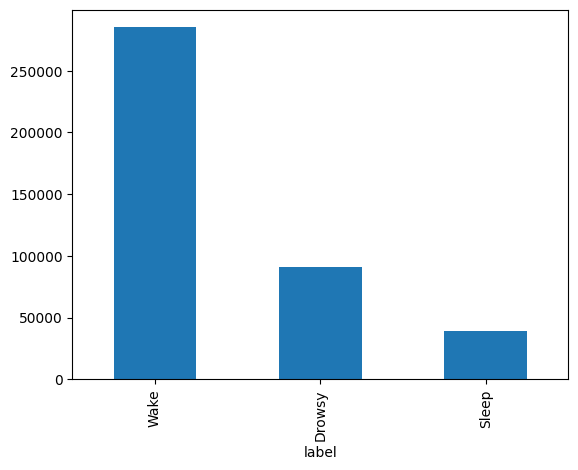

In [50]:
df_feats["label"].value_counts().plot(kind="bar")


<Axes: xlabel='label'>

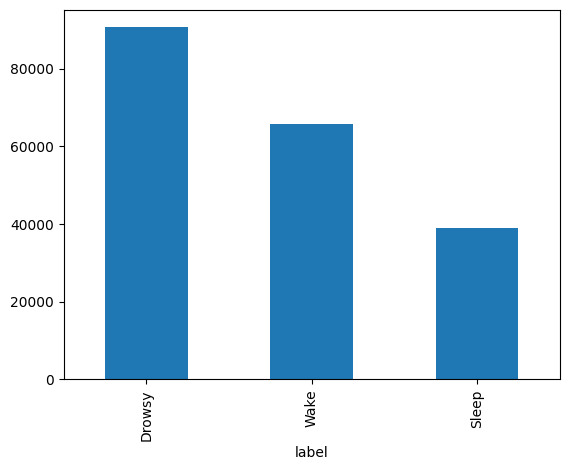

In [51]:
df_feats_trimmed_all["label"].value_counts().plot(kind="bar")


In [52]:
df_feats_trimmed_all["label"].value_counts()


label
Drowsy    90652
Wake      65642
Sleep     38874
Name: count, dtype: int64

=> There is quite some label imbalance

## EDA on features

In [53]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]


In [ ]:
import math

import matplotlib.pyplot as plt

plot_cols = [c for c in feat_cols if not "_shift=" in c]



# ML

In [55]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier

In [56]:
from src.visualizations import plot_linear_classification_coefs
from src.visualizations import plot_learning_curve
from src.visualizations import plot_confusion_matrix

## The simple, linear pipeline

In [57]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss="log_loss",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

## Linear model for SC-20

### Direct transfer from other 58 patients (114 PSGs) to SC-20

* Train & validatie on all patients except the SC-20 patients (i.e., patient_id > 19)
* Test the trained model on those 20 patients (i.e., patient_id in [0-19])

In [58]:
### Fit the pipeline
pipe.fit(df_feats_trimmed[feat_cols], df_feats_trimmed["label"])

Pipeline(steps=[('impute', SimpleImputer()),
                ('scale',
                 QuantileTransformer(n_quantiles=100, random_state=0,
                                     subsample=200000)),
                ('linear_model',
                 SGDClassifier(average=True, class_weight='balanced',
                               loss='log_loss', n_jobs=5, random_state=0))])

In [59]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed["label"], y_pred=preds))

Training data:
Log loss: 0.4087665677907914
              precision    recall  f1-score   support

      Drowsy       0.88      0.86      0.87     70049
       Sleep       0.75      0.78      0.76     25454
        Wake       0.93      0.94      0.93     57435

    accuracy                           0.88    152938
   macro avg       0.85      0.86      0.86    152938
weighted avg       0.88      0.88      0.88    152938



In [60]:
print("Testing data:")
preds = pipe.predict(df_feats_trimmed_paper[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_paper[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_paper["label"], y_pred=preds))

Testing data:
Log loss: 0.5673622161135626
              precision    recall  f1-score   support

      Drowsy       0.83      0.89      0.86     20603
       Sleep       0.87      0.74      0.80     13420
        Wake       0.88      0.93      0.90      8207

    accuracy                           0.85     42230
   macro avg       0.86      0.85      0.86     42230
weighted avg       0.85      0.85      0.85     42230



In [61]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))


F1 macro:  0.8550400461442415
Bal. Acc:  0.8602155722978243
Kappa:     0.760024710647651
Log loss : 0.5673622161135626
Acc:       0.8515983897703054


In [62]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))


F1 macro:  0.8550400461442415
Bal. Acc:  0.8602155722978243
Kappa:     0.760024710647651
Log loss : 0.5673622161135626
Acc:       0.8515983897703054


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

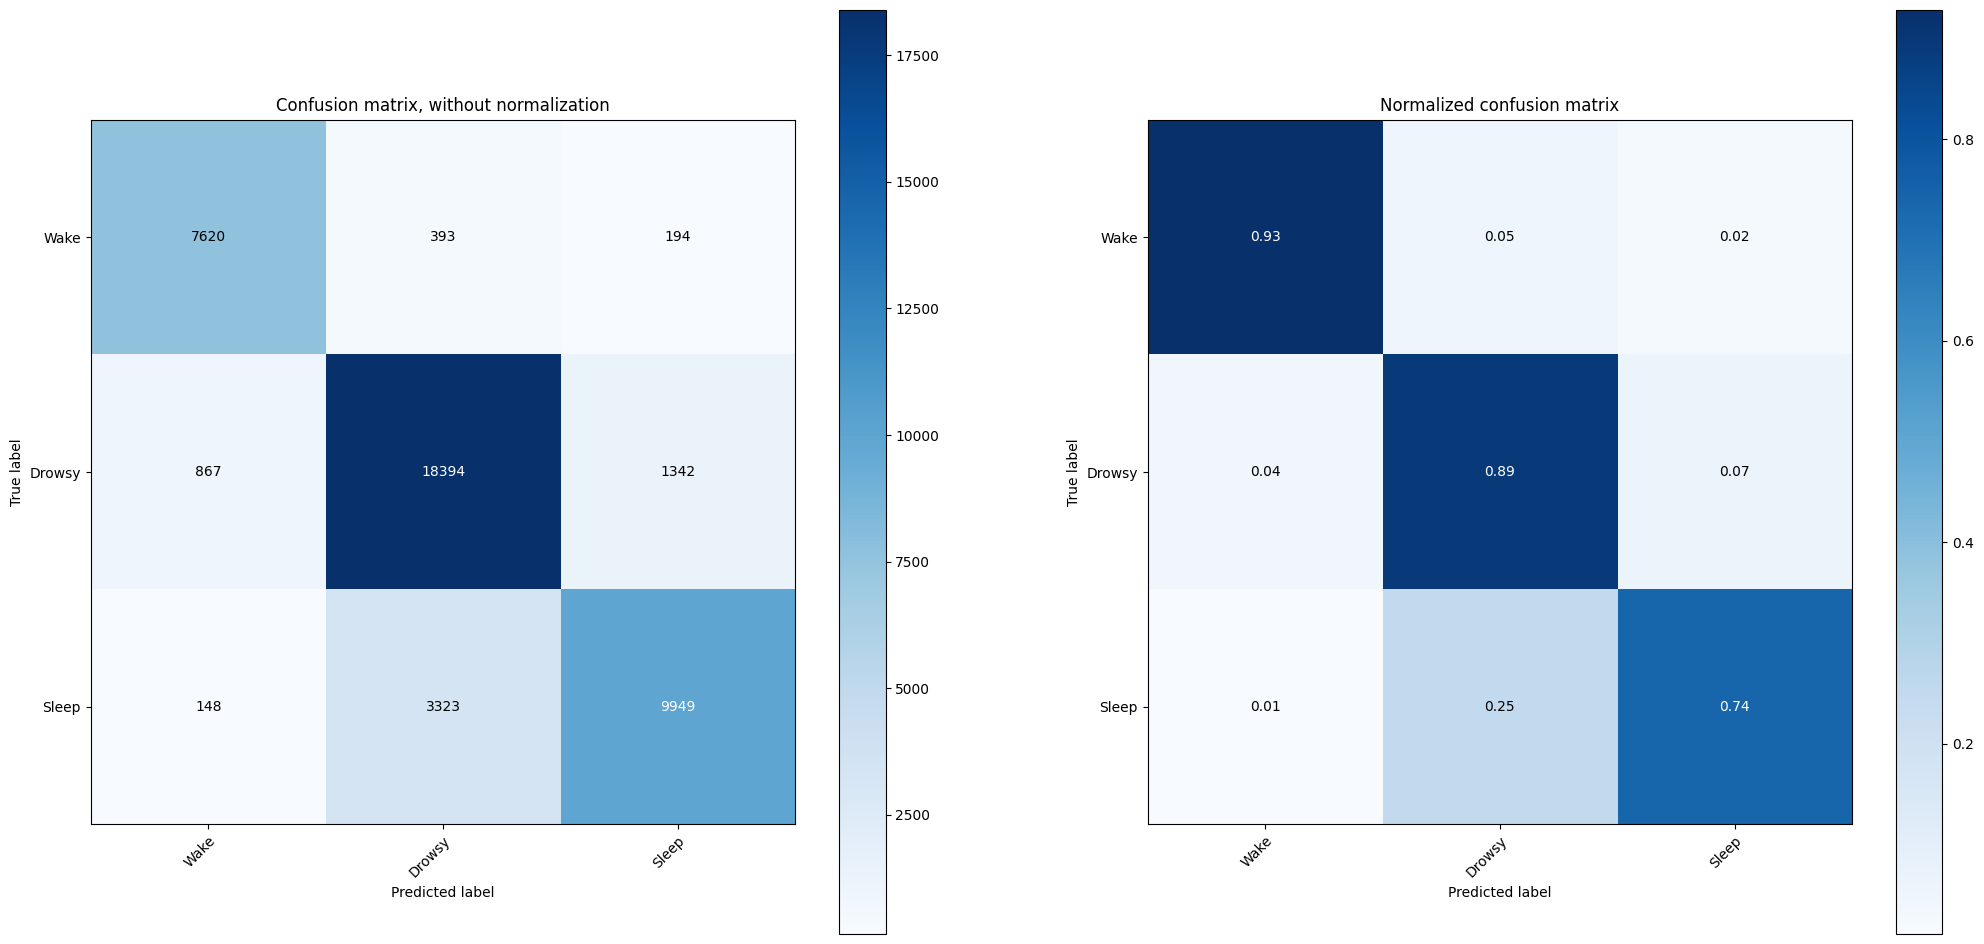

In [63]:
classes = [
    'Wake',
    'Drowsy',
    'Sleep'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=True, ax=ax)

In [64]:
import joblib
joblib.dump(pipe, "models/pipe_DT_SC-20.pkl")

['models/pipe_DT_SC-20.pkl']

#### Basic model analysis

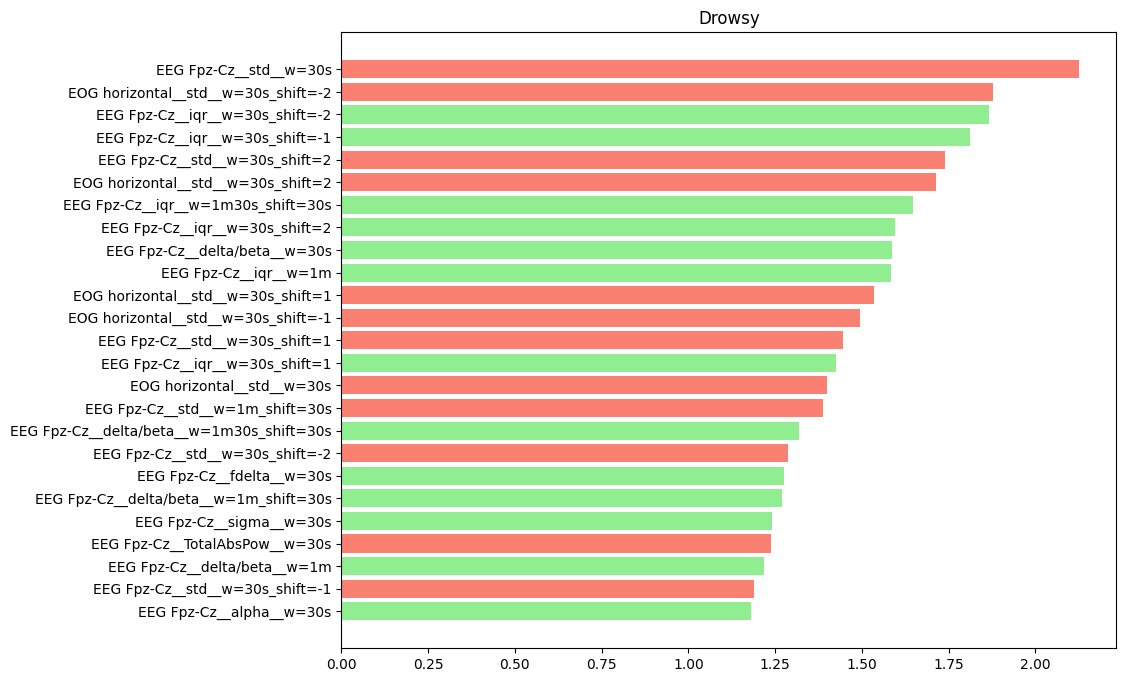

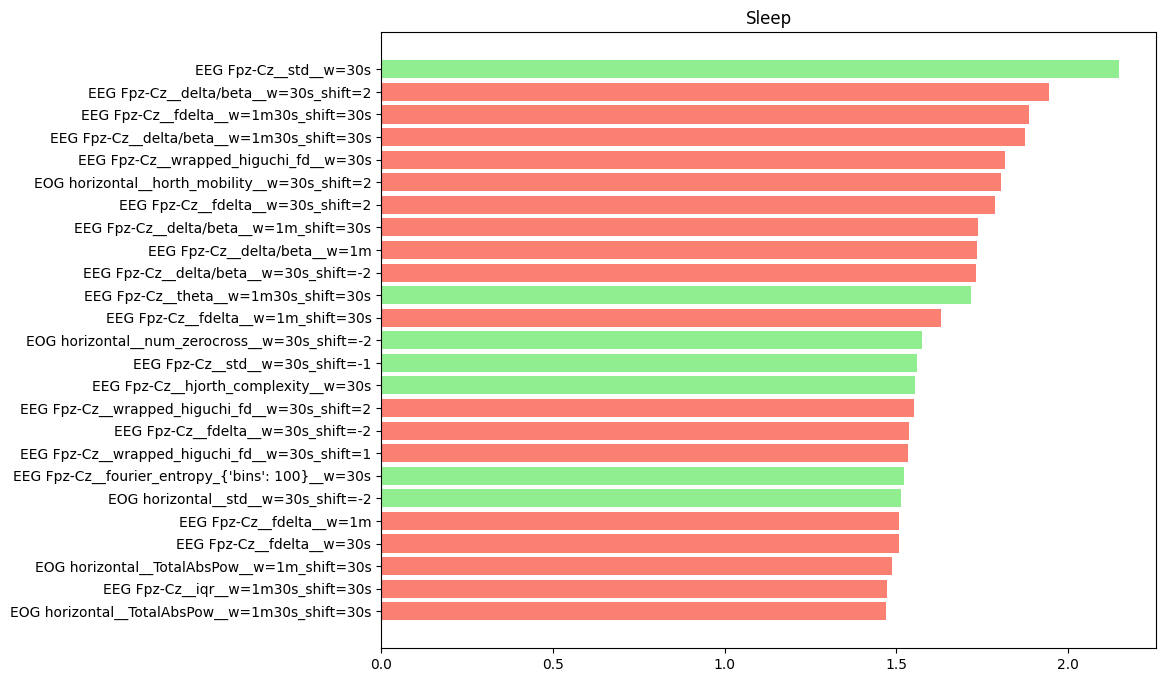

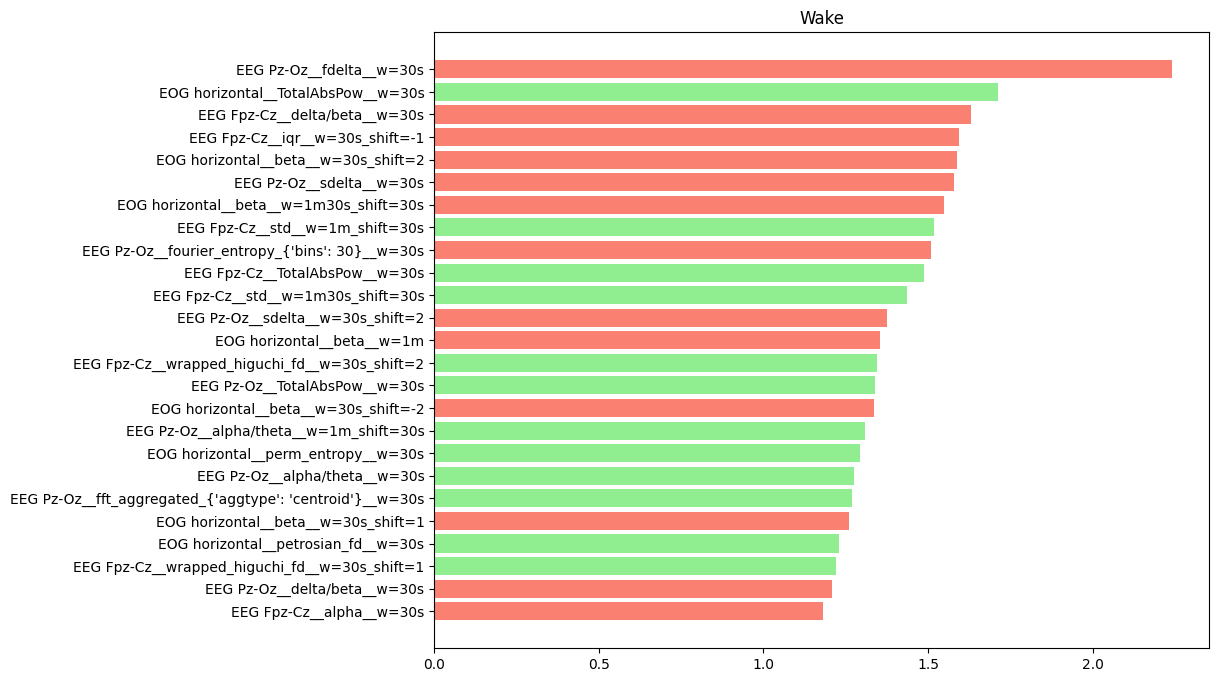

In [66]:
plot_linear_classification_coefs(pipe, feat_cols=feat_cols)

In [67]:
df_impact = pd.DataFrame()
df_impact["feature"] = feat_cols
for i, c in enumerate(pipe.classes_):
    df_impact[f"weight_{c}"] = pipe[-1].coef_[i,:]
df_impact["max_abs"] = df_impact.filter(like="weight_").abs().max(axis=1)
df_impact["mean_abs"] = df_impact.filter(like="weight_").abs().mean(axis=1)

def get_shift(feat_name: str):
    if not "shift=" in feat_name or "w=1m" in feat_name:
        return "0"
    return feat_name.split("shift=")[-1]
df_impact["shift"] = df_impact.feature.apply(get_shift)
# print(df_impact["shift"].value_counts())

def get_window_size(feat_name: str):
    return feat_name.split("__w=")[1].split("_")[0]

df_impact["win_size"] = df_impact.feature.apply(get_window_size)
# print(df_impact["win_size"].value_counts())
# print(df_impact[df_impact["shift"] == "0"]["win_size"].value_counts())

df_impact.head(5)

,feature,weight_Drowsy,weight_Sleep,weight_Wake,max_abs,mean_abs,shift,win_size
0,EEG Fpz-Cz__TotalAbsPow__w=1m,-0.270971,-0.067045,0.492128,0.492128,0.276714,0,1m
1,EEG Fpz-Cz__TotalAbsPow__w=30s,-1.239115,0.478524,1.488625,1.488625,1.068755,0,30s
2,EEG Fpz-Cz__alpha__w=1m,0.641024,-0.003032,-0.769166,0.769166,0.471074,0,1m
3,EEG Fpz-Cz__alpha__w=30s,1.180701,-0.526976,-1.181024,1.181024,0.962901,0,30s
4,EEG Fpz-Cz__beta__w=1m,-0.758204,0.846309,0.478234,0.846309,0.694249,0,1m


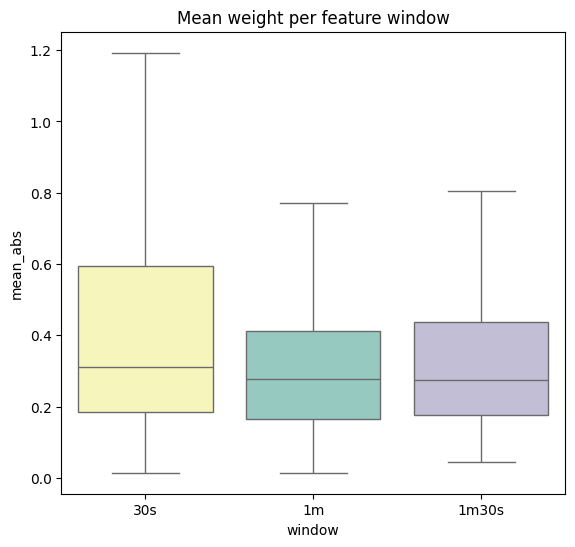

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

sub_df = df_impact[df_impact["shift"] == "0"]

plt.figure(figsize=(6.5, 6))
plt.title("Mean weight per feature window")

sns.boxplot(
    x=sub_df["win_size"].rename("window"),
    y=sub_df["mean_abs"],
    hue=sub_df["win_size"],  # Adding `hue` to align with palette
    order=["30s", "1m", "1m30s"],
    showfliers=False,
    palette="Set3",
    dodge=False  # Ensures that all hues are in the same boxplot position
)
plt.legend([], [], frameon=False)  # Removes the legend entirely
plt.show()


### Grouped X-fold on SC-20

In [74]:
# Total of 20 folds
gkfold = GroupKFold(n_splits=20)
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_paper[feat_cols],
    df_feats_trimmed_paper["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [75]:
print("20-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))


20-FOLD: TRAIN
  MACRO F1:           0.9013
  Balanced accuracy:  0.9076
  Accuracy:           0.8978
  Log loss:           0.4752


In [76]:
print("20-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


20-FOLD: TEST
  MACRO F1:           0.872
  Balanced accuracy:  0.885
  Accuracy:           0.8725
  Log loss:           0.6794


In [ ]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_paper[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_paper["label"].iloc[train_idx]
    X_test = df_feats_trimmed_paper[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_paper["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [78]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8748340489048311
ACC: 0.8713000236798485
KAPPA: 0.7950856690188699
LOG LOSS: 0.6928594827114867


In [79]:
print(classification_report(preds, y_trues))

              precision    recall  f1-score   support

      Drowsy       0.85      0.89      0.87     19689
       Sleep       0.86      0.83      0.85     13936
        Wake       0.92      0.88      0.90      8605

    accuracy                           0.87     42230
   macro avg       0.88      0.87      0.87     42230
weighted avg       0.87      0.87      0.87     42230



<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

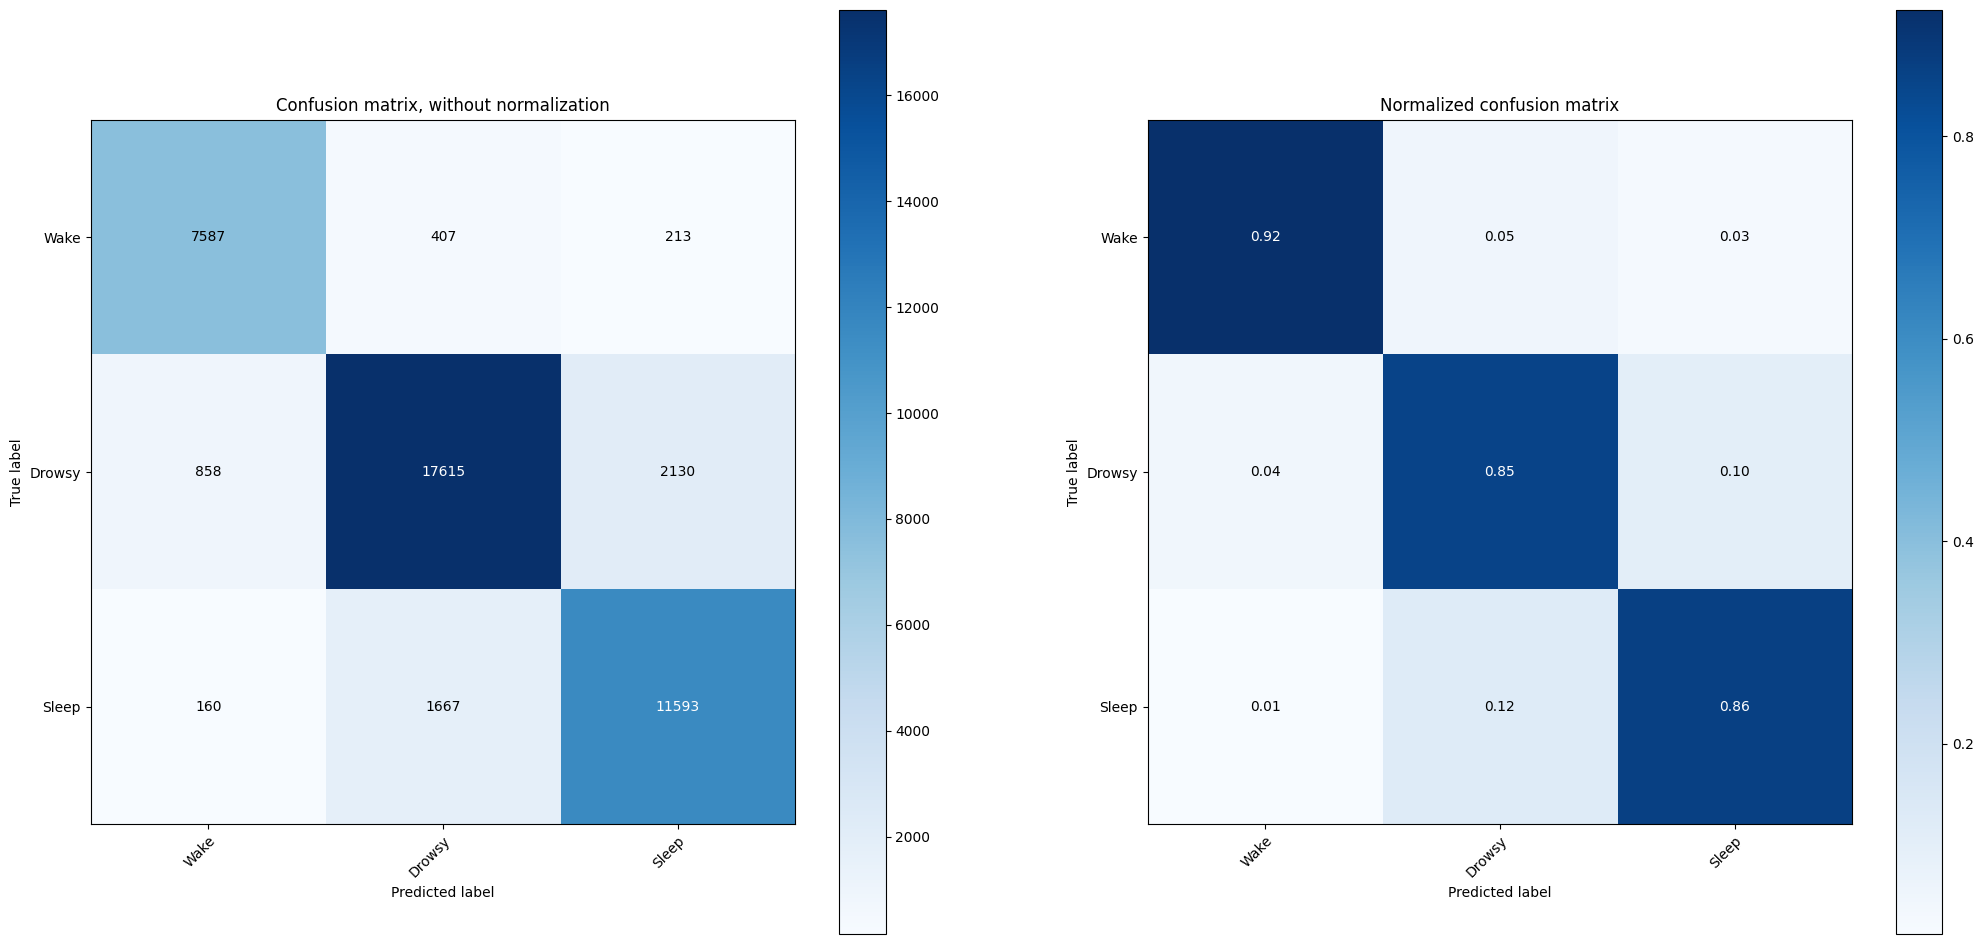

In [81]:
classes = [
    'Wake',
    'Drowsy',
    'Sleep'
]
plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

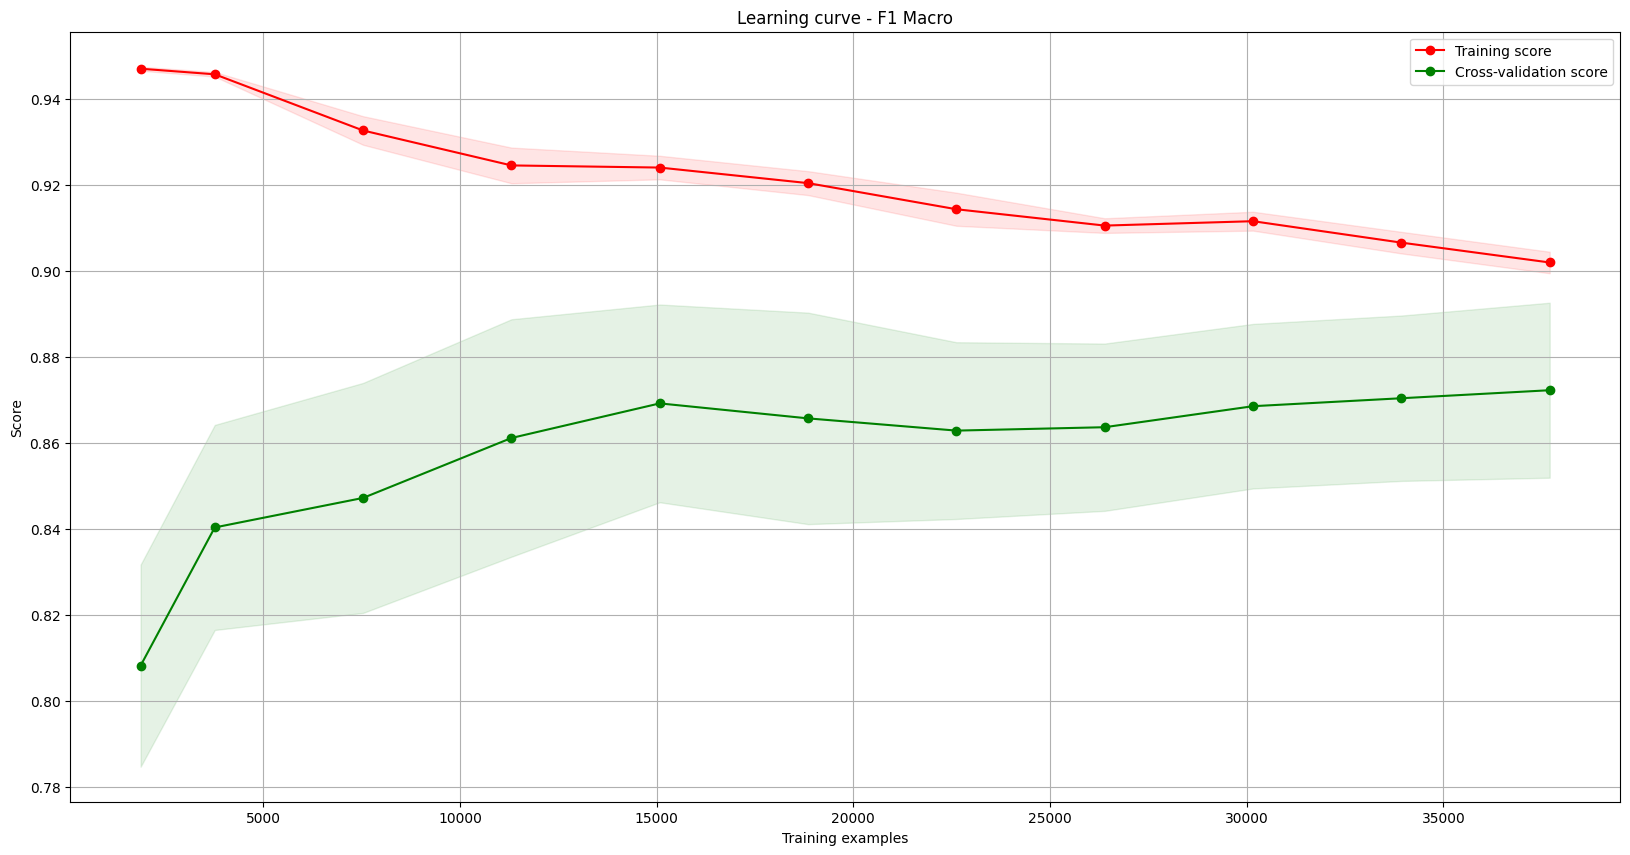

In [82]:
cv = StratifiedGroupKFold(n_splits=10).split(
    df_feats_trimmed_paper[feat_cols],
    df_feats_trimmed_paper["label"],
    groups=df_feats_trimmed_paper.patient_id,
)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats_trimmed_paper[feat_cols],
    y=df_feats_trimmed_paper["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=20,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)


## Linear model for SC-78

### Grouped X-fold on all 78 patients (153 PSGs)

In [83]:
# Total of 10 folds
gkfold = StratifiedGroupKFold(n_splits=10)
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_all[feat_cols],
    df_feats_trimmed_all["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [84]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

10-FOLD: TRAIN
  MACRO F1:           0.8635
  Balanced accuracy:  0.867
  Accuracy:           0.8743
  Log loss:           0.414


In [85]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


10-FOLD: TEST
  MACRO F1:           0.845
  Balanced accuracy:  0.849
  Accuracy:           0.8568
  Log loss:           0.4929


In [86]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_all[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_all["label"].iloc[train_idx]
    X_test = df_feats_trimmed_all[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_all["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [87]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.845493173038529
ACC: 0.8573280455812429
KAPPA: 0.7752687944018735
LOG LOSS: 0.4912117319300349


In [88]:
print(classification_report(preds, y_trues))

              precision    recall  f1-score   support

      Drowsy       0.84      0.87      0.85     87253
       Sleep       0.78      0.75      0.77     40529
        Wake       0.93      0.90      0.92     67386

    accuracy                           0.86    195168
   macro avg       0.85      0.84      0.85    195168
weighted avg       0.86      0.86      0.86    195168



<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

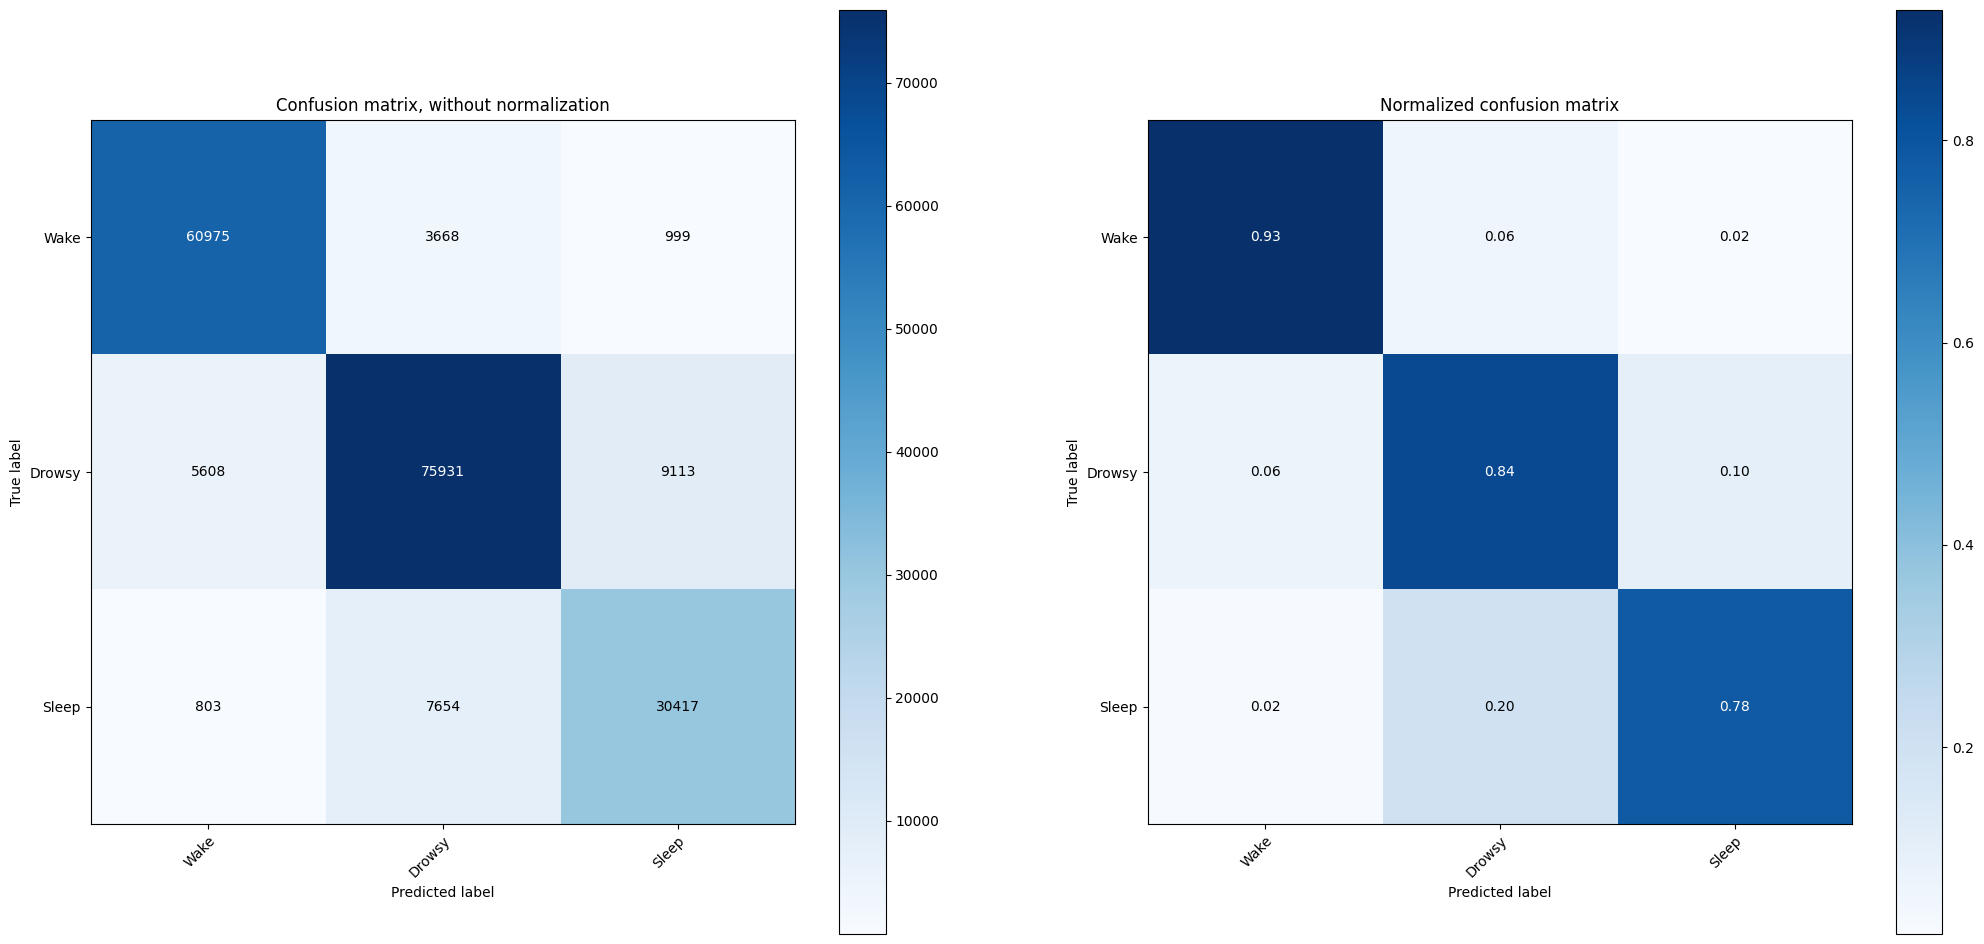

In [89]:
classes = [
    'Wake',
    'Drowsy',
    'Sleep'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

## The simple, catboost pipeline

In [96]:
### Create pipeline
from catboost import CatBoostClassifier
pipe = CatBoostClassifier(verbose=0, depth=5, n_estimators=2_000, random_state=0)

## Catboost model for SC-20

### Direct transfer from other 58 patients (114 PSGs) to SC-20

* Train & validatie on all patients except the SC-20 patients (i.e., patient_id > 19)
* Test the trained model on those 20 patients (i.e., patient_id in [0-19])

In [97]:
### Fit the pipeline
pipe.fit(df_feats_trimmed[feat_cols], df_feats_trimmed["label"])

In [98]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed["label"], y_pred=preds))

Training data:
Log loss: 0.17358384028520168
              precision    recall  f1-score   support

      Drowsy       0.92      0.95      0.93     70049
       Sleep       0.91      0.85      0.88     25454
        Wake       0.96      0.96      0.96     57435

    accuracy                           0.94    152938
   macro avg       0.93      0.92      0.93    152938
weighted avg       0.94      0.94      0.94    152938



In [99]:
print("Testing data:")
preds = pipe.predict(df_feats_trimmed_paper[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_paper[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_paper["label"], y_pred=preds))

Testing data:
Log loss: 0.2661089289820275
              precision    recall  f1-score   support

      Drowsy       0.89      0.91      0.90     20603
       Sleep       0.90      0.85      0.87     13420
        Wake       0.91      0.93      0.92      8207

    accuracy                           0.89     42230
   macro avg       0.90      0.90      0.90     42230
weighted avg       0.89      0.89      0.89     42230



In [100]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))


F1 macro:  0.8969016103001964
Bal. Acc:  0.8980953332850817
Kappa:     0.8303344585965322
Log loss : 0.2661089289820275
Acc:       0.8945536348567369


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

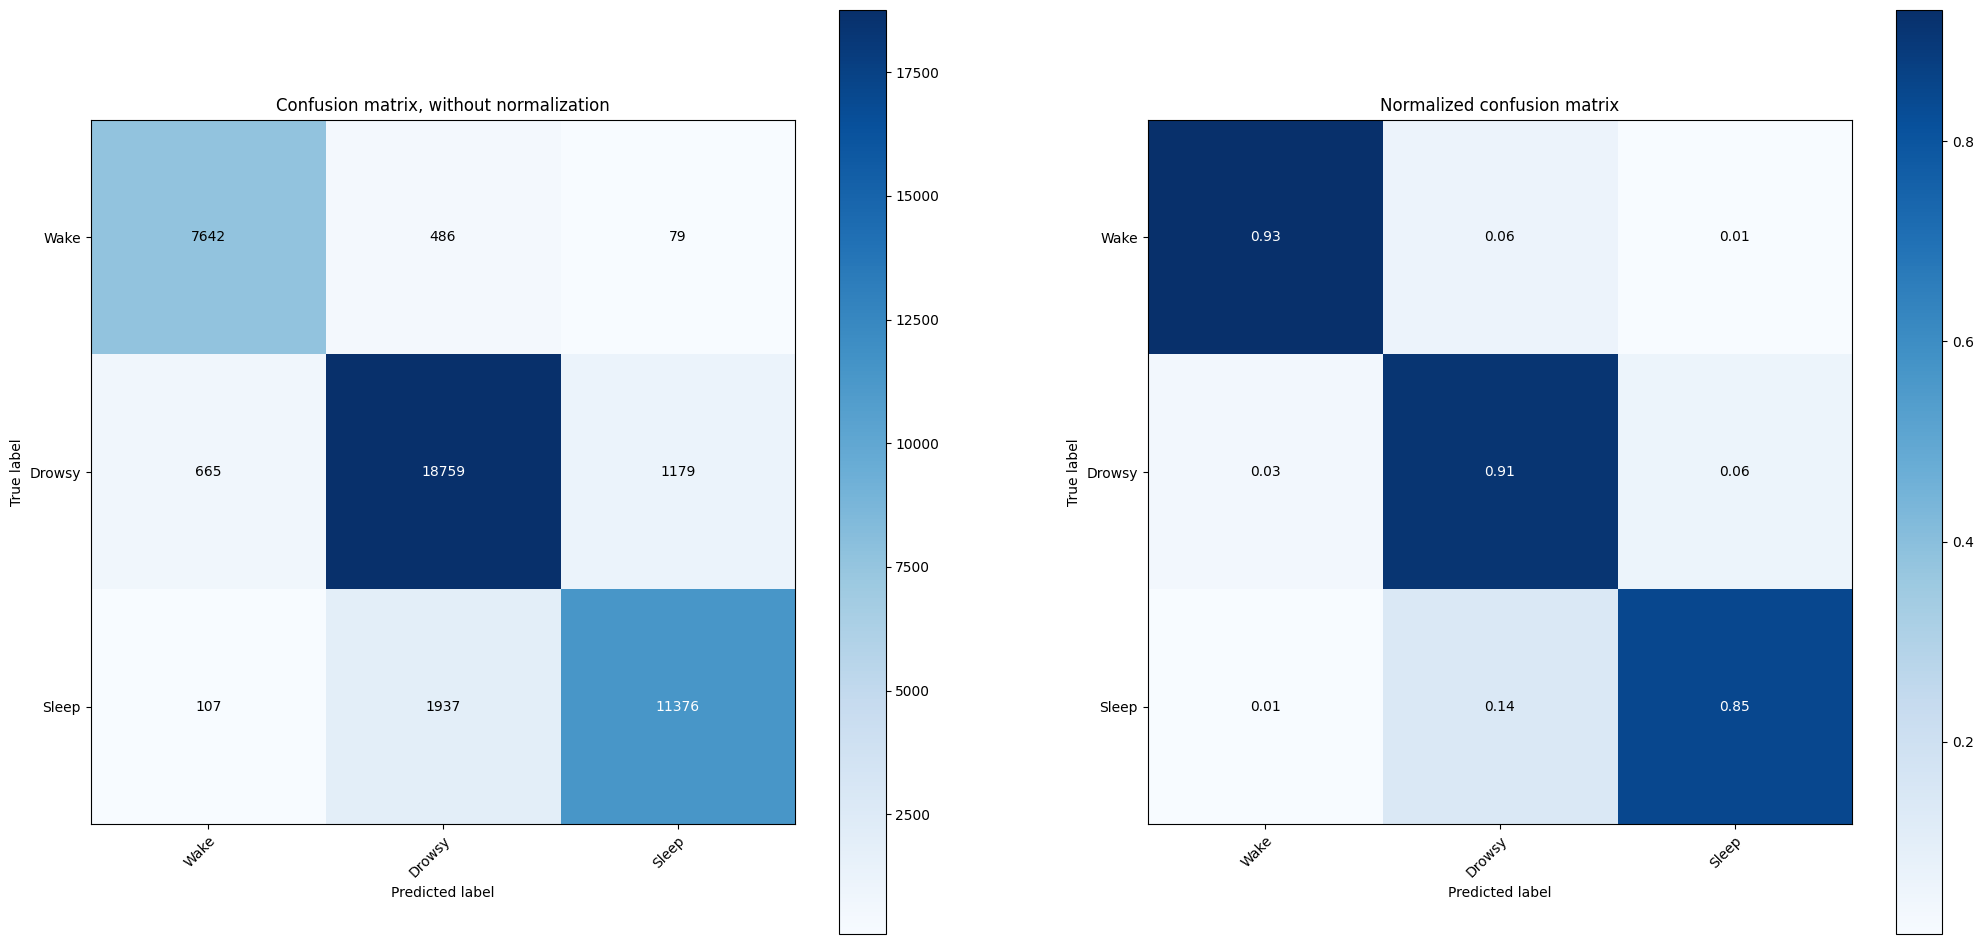

In [101]:
classes = [
    'Wake',
    'Drowsy',
    'Sleep'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=True, ax=ax)

In [103]:
import joblib
joblib.dump(pipe, "models/catboost_DT_SC-20.pkl")

['models/catboost_DT_SC-20.pkl']

### Grouped X-fold on SC-20

In [113]:
# Total of 20 folds
gkfold = GroupKFold(n_splits=20)
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_paper[feat_cols],
    df_feats_trimmed_paper["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    # n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [114]:
print("20-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

20-FOLD: TRAIN
  MACRO F1:           0.9636
  Balanced accuracy:  0.9624
  Accuracy:           0.9618
  Log loss:           0.1215


In [115]:
print("20-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


20-FOLD: TEST
  MACRO F1:           0.8921
  Balanced accuracy:  0.8959
  Accuracy:           0.8935
  Log loss:           0.2702


In [116]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_paper[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_paper["label"].iloc[train_idx]
    X_test = df_feats_trimmed_paper[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_paper["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test).ravel()]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [117]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8914350686085086
ACC: 0.8910253374378404
KAPPA: 0.824519386453499
LOG LOSS: 0.2767984191092377


In [118]:
print(classification_report(preds, y_trues))

              precision    recall  f1-score   support

      Drowsy       0.91      0.89      0.90     21021
       Sleep       0.87      0.88      0.88     13184
        Wake       0.89      0.91      0.90      8025

    accuracy                           0.89     42230
   macro avg       0.89      0.89      0.89     42230
weighted avg       0.89      0.89      0.89     42230



<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

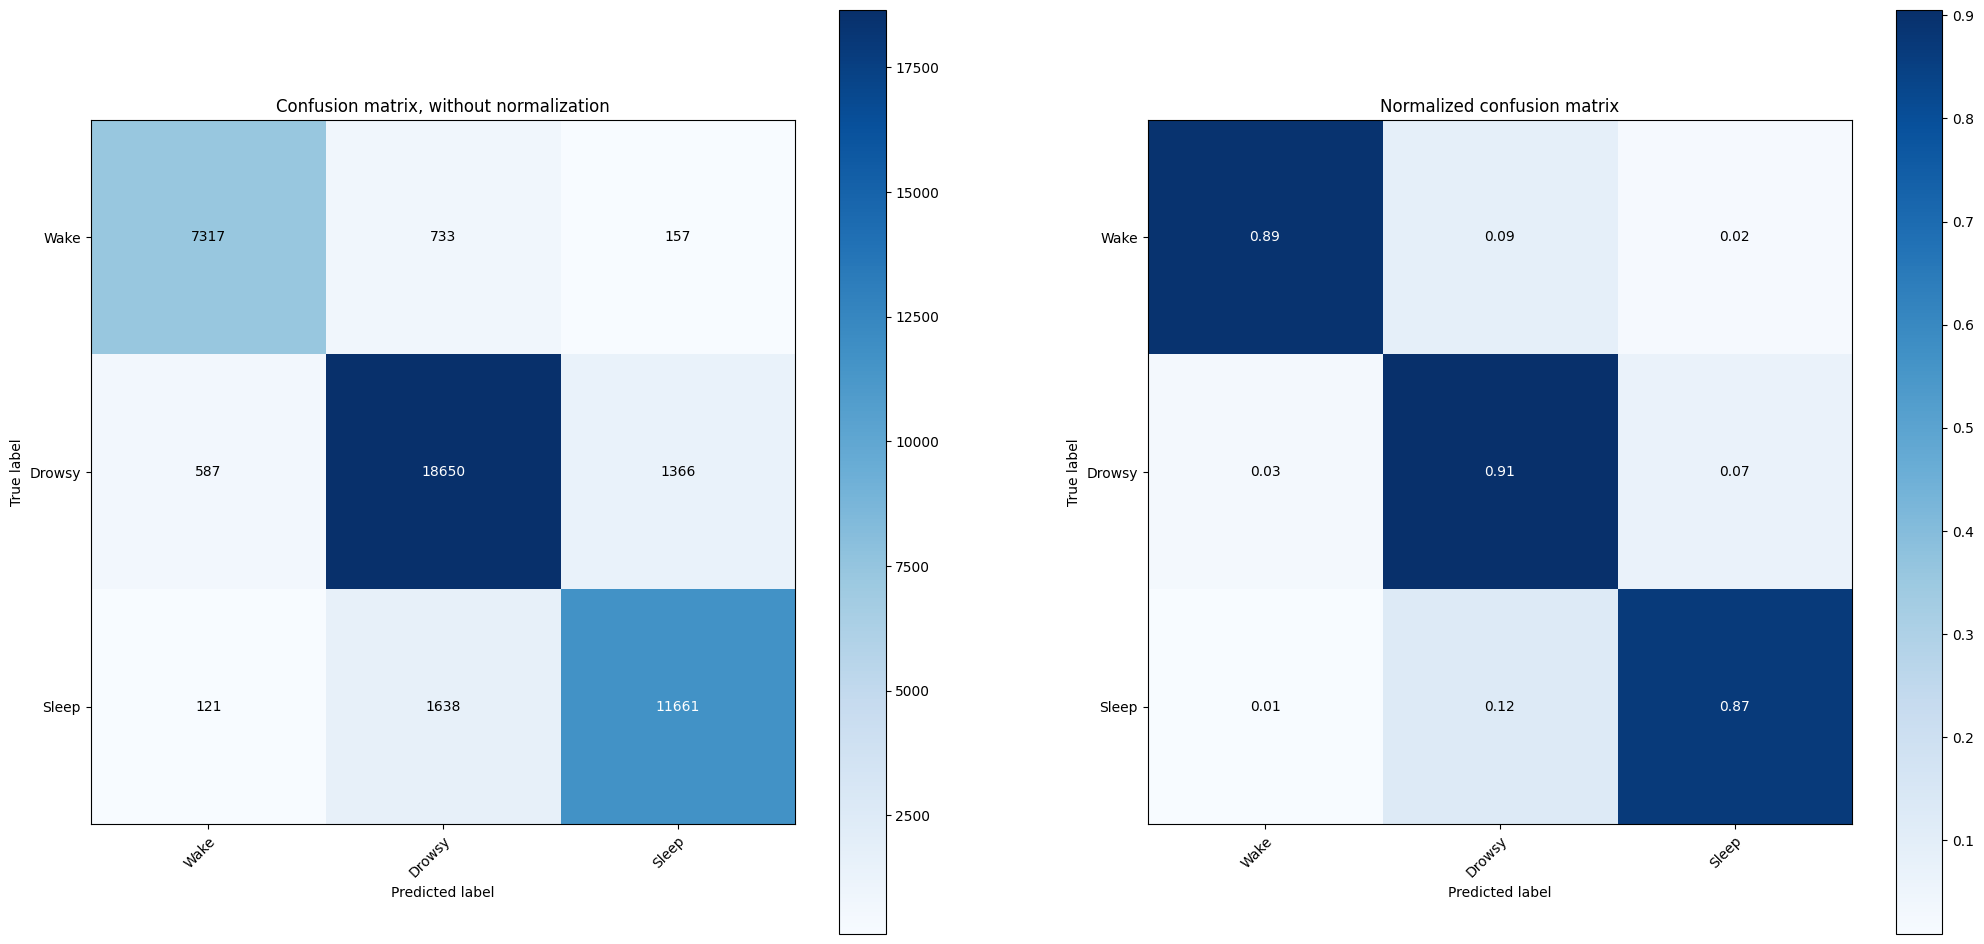

In [119]:
classes = [
    'Wake',
    'Drowsy',
    'Sleep'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

## Catboost model for SC-78

### Grouped X-fold on all 78 patients (153 PSGs)

In [ ]:
# Total of 10 folds
gkfold = StratifiedGroupKFold(n_splits=10)
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_all[feat_cols],
    df_feats_trimmed_all["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    # n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [ ]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))


10-FOLD: TRAIN
  MACRO F1:           0.8611
  Balanced accuracy:  0.8491
  Accuracy:           0.8974
  Log loss:           0.2736


In [ ]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


10-FOLD: TEST
  MACRO F1:           0.773
  Balanced accuracy:  0.7641
  Accuracy:           0.831
  Log loss:           0.4398


In [ ]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_all[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_all["label"].iloc[train_idx]
    X_test = df_feats_trimmed_all[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_all["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test).ravel()]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [ ]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.7745358585116534
ACC: 0.831140350877193
KAPPA: 0.7653336785403284
LOG LOSS: 0.4394372921808861


In [ ]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.42      0.52      0.46     17297
Sleep stage 2       0.88      0.82      0.85     73950
Sleep stage 3       0.78      0.84      0.81     12232
Sleep stage R       0.80      0.84      0.82     24646
Sleep stage W       0.93      0.91      0.92     67043

     accuracy                           0.83    195168
    macro avg       0.76      0.79      0.77    195168
 weighted avg       0.84      0.83      0.84    195168



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

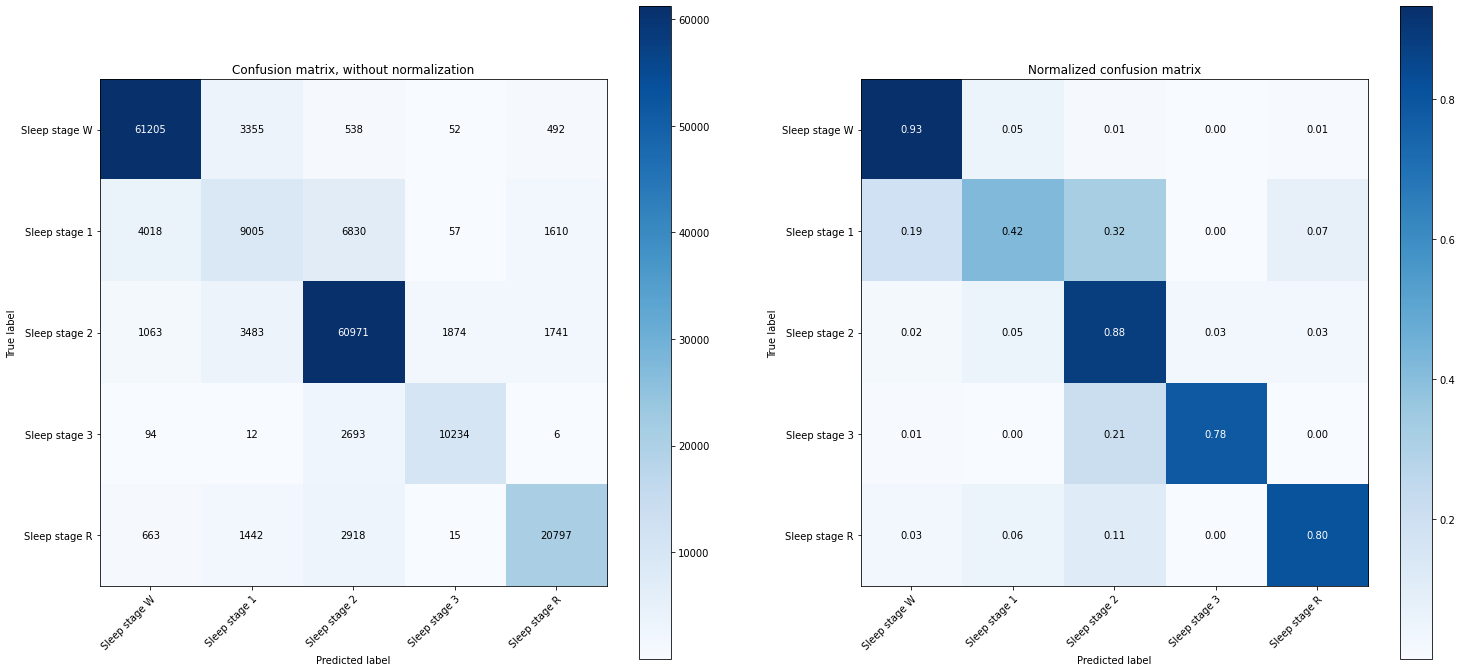

In [ ]:
classes = [
    'Wake',
    'Drowsy',
    'Sleep'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)